# NICAR Workshop: Machine Learning and NLP #2

By Jeff Kao, ProPublica (jeff.kao[at]propublica.org)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from IPython.display import display
from IPython.display import Image
# display options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_colwidth = 1000

## Before you start: 
Run everything before **Re-introduction** (because it takes a while).
### Download and unzip the data
Save the twitter data to `./data`.
* web page: https://about.twitter.com/en_us/values/elections-integrity.html#data
* account data: https://storage.googleapis.com/twitter-election-integrity/hashed/ira/ira_users_csv_hashed.zip
* tweet data: https://storage.googleapis.com/twitter-election-integrity/hashed/ira/ira_tweets_csv_hashed.zip

Uncomment the below if you need to unzip the files (or figure out where they are).

In [2]:
# !ls ./data/

In [3]:
# !unzip ./data/ira_tweets_csv_hashed.zip -d ./data/

In [4]:
# !unzip ./data/ira_users_csv_hashed.zip -d ./data/

### Load the Data into memory

Let's load the `.csv` of user accounts into pandas.

In [5]:
%%time
df_users = pd.read_csv('./data/ira_users_csv_hashed.csv', index_col='userid')

CPU times: user 57.9 ms, sys: 10.4 ms, total: 68.3 ms
Wall time: 70.9 ms


Let's load the `.csv` of tweets into pandas (might take a couple of minutes).

In [6]:
%%time
df_tweets = pd.read_csv('./data/ira_tweets_csv_hashed.csv', index_col='tweetid')

<string>:2: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


CPU times: user 1min 21s, sys: 5.7 s, total: 1min 27s
Wall time: 1min 27s


## Re-introduction

Wow, part 1 contained a lot of dataviz and ML! We're finally on our way to our ultimate goal. Clustering documents using NLP.

Let's reset for part 2.

### What did we just do?

In part 1, we used some off-the-shelf algorithms to reduce high-dimensional data and/or cluster it. We also visualized the results of that process to gain an intuitive, high-level understanding of how these algorithms work.

### How is that useful, again?

Breaking down lots of text using NLP involves doing the same things that we did in part 1 (dimension reduction and clustering). The only difference is how the data is represented.

Instead of features that represent pixel darkness or petal length, we now have to somehow represent words as numbers. Once we can do that, we can reduce dimensions, visualize and cluster words-as-numbers in the same way!

### What if I didn't understand [insert idea here] in part 1?

It's a lot to go through at once, but a high-level understanding is good enough for now if you have working code. As we play with the data, visualize it, and dig deeper into the algorithms (and possibly the math behind it), we'll get a better understanding of what's happening. It's an iterative process.

Again, I'll be posting these notebooks on [propublica's github](https://github.com/propublica) for your future use & play.

Alright, hopefully our datasets have loaded by now! Let's dig in!

## Preliminary Exploration
Let's take a peek at our accounts and the tweets.

In [7]:
print(f'There are {df_users.shape[0]} IRA accounts and {df_users.shape[1]} columns.')
print("Here's a sample of 5 accounts:")
df_users.sample(5, random_state=42)

There are 3608 IRA accounts and 9 columns.
Here's a sample of 5 accounts:


,user_display_name,user_screen_name,user_reported_location,user_profile_description,user_profile_url,follower_count,following_count,account_creation_date,account_language
userid,,,,,,,,,
10702d26095f66cc83925c4bcb1f1848f122769fbdbc820b7c2ca02a35efbd6c,10702d26095f66cc83925c4bcb1f1848f122769fbdbc820b7c2ca02a35efbd6c,10702d26095f66cc83925c4bcb1f1848f122769fbdbc820b7c2ca02a35efbd6c,Омск,Студентка (ОмГУПС) Активна во всех отношениях #ZaKorobkova,NaN,137,616,2014-06-06,ru
20cec8927074f5f846ea12d67c8676de880ccc36f5b95f31255a1ada1bd75996,20cec8927074f5f846ea12d67c8676de880ccc36f5b95f31255a1ada1bd75996,20cec8927074f5f846ea12d67c8676de880ccc36f5b95f31255a1ada1bd75996,USA,Coffeeaholic,NaN,99,110,2013-08-24,en
1570897635418db8791ea027bbca69c85470235651ae10ac5154b4022ff0a758,1570897635418db8791ea027bbca69c85470235651ae10ac5154b4022ff0a758,1570897635418db8791ea027bbca69c85470235651ae10ac5154b4022ff0a758,NaN,NaN,NaN,82,163,2014-05-29,en
75260a9a180575743d360235084b16675248455e83c04bceda90043e50c86c4f,75260a9a180575743d360235084b16675248455e83c04bceda90043e50c86c4f,75260a9a180575743d360235084b16675248455e83c04bceda90043e50c86c4f,portland,love yourself or no one will love you,NaN,4186,3308,2013-07-27,en
63a0d3366f8f86855ede284abf02877c333b869bf276b5651f045d3a7fb63e8f,63a0d3366f8f86855ede284abf02877c333b869bf276b5651f045d3a7fb63e8f,63a0d3366f8f86855ede284abf02877c333b869bf276b5651f045d3a7fb63e8f,"Днепр, Украина","Видим, слышим и говорим о том, что происходит на Украине на самом деле.",https://t.co/z3bIaj6p59,675,2299,2016-09-26,ru


Let's also look at the tweets themselves.

In [8]:
print(f'There are {df_tweets.shape[0]} tweets from IRA accounts and {df_tweets.shape[1]} columns.')
print("Here's a sample of 10 tweets:")
df_tweets.sample(10, random_state=42)

There are 8768633 tweets from IRA accounts and 30 columns.
Here's a sample of 10 tweets:


,userid,user_display_name,user_screen_name,user_reported_location,user_profile_description,user_profile_url,follower_count,following_count,account_creation_date,account_language,tweet_language,tweet_text,tweet_time,tweet_client_name,in_reply_to_tweetid,in_reply_to_userid,quoted_tweet_tweetid,is_retweet,retweet_userid,retweet_tweetid,latitude,longitude,quote_count,reply_count,like_count,retweet_count,hashtags,urls,user_mentions,poll_choices
tweetid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
663675383926145024,103a0c1f94dde393110777de9fdfa42aaec6b9b5a8274d1ddeee4e5bd2e12adb,103a0c1f94dde393110777de9fdfa42aaec6b9b5a8274d1ddeee4e5bd2e12adb,103a0c1f94dde393110777de9fdfa42aaec6b9b5a8274d1ddeee4e5bd2e12adb,россия,мур мурлык мурлы,NaN,176,1074,2014-05-02,ru,ru,RT @GazetaRu_All: DM: миграционный кризис обошелся британскому бизнесу в &amp;pound;660 млн https://t.co/bAEJAYYKPz,2015-11-09 11:11,iziaslav,NaN,NaN,NaN,True,70416094,6.636669e+17,absent,absent,0.0,0.0,0.0,0.0,[],[http://www.gazeta.ru/business/news/2015/11/09/n_7864613.shtml?utm_source=google&utm_medium=banner&utm_campaign=all],[70416094],NaN
605605176628637696,d9d4b2d748fd37611d4f695fbce9830e26ea45a5b720f39a4380c3382cc77071,d9d4b2d748fd37611d4f695fbce9830e26ea45a5b720f39a4380c3382cc77071,d9d4b2d748fd37611d4f695fbce9830e26ea45a5b720f39a4380c3382cc77071,Новгород,"Десантник, патриот. Ныне автослесарь.",NaN,819,2000,2014-03-14,ru,ru,RT @riafanru: В Китае спасены 30 из 460 пассажиров затонувшего теплохода http://t.co/l5RBbQf5sD http://t.co/gsCXm3JEOR,2015-06-02 05:21,slovoslav,NaN,NaN,NaN,True,2570574680,6.055773e+17,absent,absent,0.0,0.0,0.0,0.0,[],[http://riafan.ru/297115-v-kitae-spasenyi-30-iz-460-passazhirov-zatonuvshego-teplohoda/],[2570574680],NaN
600272549537312768,8ba39b9a4a244da8c0db0252abde162c7601e9d718d2daf6024c4233550c60ca,8ba39b9a4a244da8c0db0252abde162c7601e9d718d2daf6024c4233550c60ca,8ba39b9a4a244da8c0db0252abde162c7601e9d718d2daf6024c4233550c60ca,Новгород,Балетмейстер,NaN,216,386,2014-05-11,en,ru,"RT @NovostiKzn: ""Последний звонок"" для школьников Казани прозвенит 21 мая http://t.co/5XNDbVTpwe",2015-05-18 12:11,rostislav,NaN,NaN,NaN,True,2573726278,6.002611e+17,absent,absent,0.0,0.0,0.0,0.0,[],[http://bit.ly/1cKCRMp],[2573726278],NaN
631482168695353345,2530830345,New Orleans Online,NewOrleansON,"New Orleans, LA","Breaking news, weather, traffic and more for New Orleans and Louisiana. DM us anytime. RTs not endorsements",NaN,35988,11010,2014-05-05,en,en,"Former LSU RB Alfred Blue atop Houston Texans' depth chart following Arian Foster injury, #news",2015-08-12 15:07,twitterfeed,NaN,NaN,NaN,False,NaN,NaN,absent,absent,0.0,0.0,1.0,2.0,[news],[],NaN,NaN
515059219910127616,0490d46f62ce81404695f5b3496d3130276761fc5d66bdd362ca865dac72dc41,0490d46f62ce81404695f5b3496d3130276761fc5d66bdd362ca865dac72dc41,0490d46f62ce81404695f5b3496d3130276761fc5d66bdd362ca865dac72dc41,Moscow,I'm mothafuckin' rich bitch,NaN,191,219,2014-05-05,en,und,RT @dab36567cc11009216e9c299b8c15e3ff020f19417b4a5f142de1fef4a6d02c8: https://t.co/bfvLZEfxkh http://t.co/XncgfeEiY7 #ДАВАЙСОГРЕЕМСЯ,2014-09-25 08:44,TweetDeck,NaN,NaN,NaN,True,dab36567cc11009216e9c299b8c15e3ff020f19417b4a5f142de1fef4a6d02c8,5.150590e+17,absent,absent,0.0,0.0,0.0,0.0,[ДАВАЙСОГРЕЕМСЯ],[http://boeing-is-back.livejournal.com/20690.html],[dab36567cc11009216e9c299b8c15e3ff020f19417b4a5f142de1fef4a6d02c8],NaN
888325518948487168,7be038f047ded532d42dc010c571831b6fe7807f154c946163690f1cb0031c4a,7be038f047ded532d42dc010c571831b6fe7807f154c946163690f1cb0031c4a,7be038f047ded532d42dc010c571831b6fe7807f154c946163690f1cb0031c4a,"München, Bayern",Lokale Nachrichten aus München. Hier kannst Du wichtige und aktuelle Nachrichten finden. Lies die News aus Deiner Stadt und schreib uns in die DN!,NaN,1520,1786,2016-05-20,de,de,Sie verloren ihr Nesthäkchen beim OEZ-Amoklauf https://t.co/mXXyUQHiEC https://t.co/ubA9PmF6OS,2017-07-21 09:11,Twibble.io,NaN,NaN,NaN,False,NaN,NaN,absent,absent,0.0,0.0,0.0,0.0,[],[https://www.merkur.de/lokales/muenchen/stadt-muenchen/amo

Hmm, it appears that not everyone is tweeting in english -- so what language are they using?

Top 10 account languages:


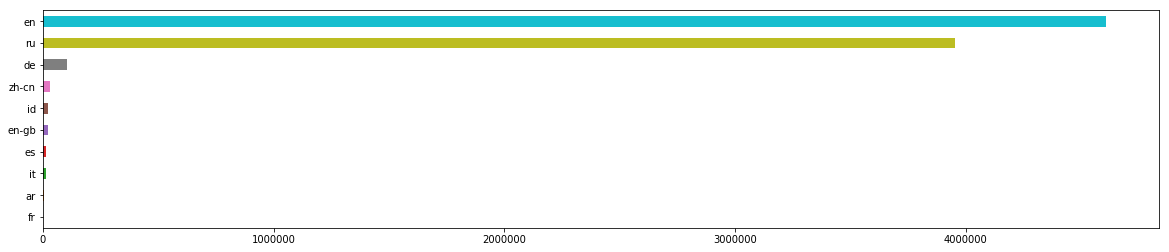

In [9]:
print("Top 10 account languages:")
df_tweets['account_language'].value_counts()[:10][::-1].plot.barh(figsize=(20,4));

Top 10 tweet languages:


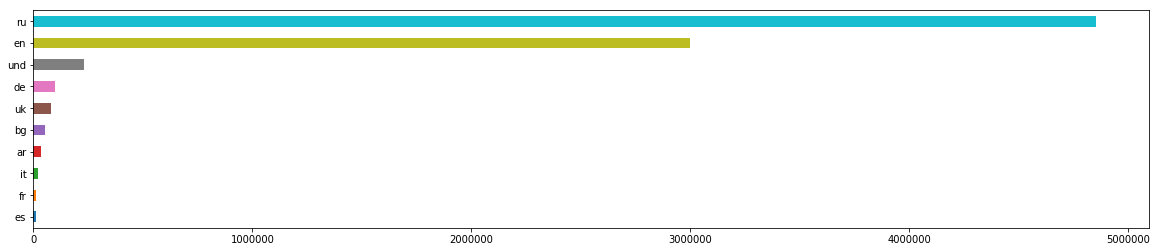

In [10]:
print("Top 10 tweet languages:")
df_tweets['tweet_language'].value_counts()[:10][::-1].plot.barh(figsize=(20,4));

Okay, that's a lot of users and a lot of tweets. Let's cut down the size of our problem by looking at english-speaking accounts and their english tweets, only.

In [11]:
%%time
# English-speaking accounts only
df_users_eng = df_users[df_users['account_language'] == 'en']
# English tweets only
df_tweets_eng = df_tweets[df_tweets['tweet_language'] == 'en']
# English tweets from english-speaking accounts only
df_tweets_eng = df_tweets_eng[df_tweets_eng['userid'].isin(df_users_eng.index)]

CPU times: user 2.28 s, sys: 469 ms, total: 2.75 s
Wall time: 2.63 s


It's also easier to analyze documents when they're longer. Since tweets are so short, individually, let's aggregate all of a user's tweets to make our analysis a bit easier.

In [12]:
df_users_eng_tweettext = \
(df_tweets_eng[['userid','tweet_text']]
 .groupby('userid')
 .agg({'userid': 'first', 'tweet_text': lambda x: ' '.join(x)})
 .set_index('userid')
)

We're going to have to dig into accounts later on, so let's define some functions that fetch out some useful information about an account, given their userid.

In [13]:
# useful columns for a tweet
tweet_cols = [
       'tweet_text', 'tweet_time', 'tweet_client_name', 
       'in_reply_to_tweetid', 'in_reply_to_userid', 'quoted_tweet_tweetid', 
       'quote_count', 'reply_count', 'like_count', 'retweet_count',
       'is_retweet', 'retweet_userid', 'retweet_tweetid']

def get_users(userids):
    # return the relevant user row(s)
    return df_users.loc[userids,:]

def get_tweets_eng_for_users(userids, reduced_cols=True):
    # return the relevant english tweets in time order
    out = df_tweets_eng[df_tweets_eng['userid'].isin(userids)].sort_values(by='tweet_time', ascending=True)
    if reduced_cols:
        return out[['userid', 'tweet_text', 'tweet_time', 'tweet_client_name']]
    else:
        return out[tweet_cols]

Let's pull a few random users and look at them:

In [14]:
for count, userid in enumerate(df_users_eng.sample(4, random_state=42).index):
    print('='*100)
    print(f'User Number {count+1}:')
    print(get_users(userid))
    display(get_tweets_eng_for_users([userid]))

User Number 1:
user_display_name           fe224b0c73e2770146cbb65dcc10392b217d5c9b2ec625a702947d200150b2d3
user_screen_name            fe224b0c73e2770146cbb65dcc10392b217d5c9b2ec625a702947d200150b2d3
user_reported_location                                                                   USA
user_profile_description                                                                 NaN
user_profile_url                                                                         NaN
follower_count                                                                           137
following_count                                                                           83
account_creation_date                                                             2013-08-11
account_language                                                                          en
Name: fe224b0c73e2770146cbb65dcc10392b217d5c9b2ec625a702947d200150b2d3, dtype: object


,userid,tweet_text,tweet_time,tweet_client_name
tweetid,,,,
552452224220397568,fe224b0c73e2770146cbb65dcc10392b217d5c9b2ec625a702947d200150b2d3,"Sometimes people with the best intentions don't realize how racist they seem.Accidental Racism ,Will Make You Cringe",2015-01-06 13:10,Twitter Web Client
552452409524768769,fe224b0c73e2770146cbb65dcc10392b217d5c9b2ec625a702947d200150b2d3,Nothing Great Was Ever Achieved Without Enthusiam. Ralph Waldo,2015-01-06 13:11,Twitter Web Client
552452653301923841,fe224b0c73e2770146cbb65dcc10392b217d5c9b2ec625a702947d200150b2d3,A day without a friend is like a pot without a single drop of honey left inside. – Pooh,2015-01-06 13:12,Twitter Web Client
552452666262310912,fe224b0c73e2770146cbb65dcc10392b217d5c9b2ec625a702947d200150b2d3,Getting something done is an accomplishment,2015-01-06 13:12,Twitter Web Client
552452804611428352,fe224b0c73e2770146cbb65dcc10392b217d5c9b2ec625a702947d200150b2d3,"You forget what you want to remember, and you remember what you want to forget.",2015-01-06 13:13,Twitter Web Client
552452888640098305,fe224b0c73e2770146cbb65dcc10392b217d5c9b2ec625a702947d200150b2d3,"Earth provides enough to satisfy every man's needs, but not every man's greed. – Mahatma Gandhi",2015-01-06 13:13,Twitter Web Client
552453178542018560,fe224b0c73e2770146cbb65dcc10392b217d5c9b2ec625a702947d200150b2d3,"You give my regards to St. Peter, or whoever has his job, but in Hell.",2015-01-06 13:14,Twitter Web Client
552453350965665792,fe224b0c73e2770146cbb65dcc10392b217d5c9b2ec625a702947d200150b2d3,Summer vacation: Sleeping in the AM and waking in the PM. #dailyteen,2015-01-06 13:15,Twitter Web Client
552453582331871232,fe224b0c73e2770146cbb65dcc10392b217d5c9b2ec625a702947d200150b2d3,"A laugh can be a very powerful thing. Sometimes in life, it’s the only weapon we've got. –Roger (Who Framed Roger Rabbit)",2015-01-06 13:16,Twitter Web Client


User Number 2:
user_display_name                                ce7b9f8c86dfbf9b2bd03eda62f0d42ac1c2b1b593ba0b0b052210acf652f896
user_screen_name                                 ce7b9f8c86dfbf9b2bd03eda62f0d42ac1c2b1b593ba0b0b052210acf652f896
user_reported_location                                                                                        USA
user_profile_description    'As long as we try, maybe things will change' -pac #BlackLivesMatter #PrayForTheWorld
user_profile_url                                                                                              NaN
follower_count                                                                                                876
following_count                                                                                               950
account_creation_date                                                                                  2013-08-09
account_language                                                         

,userid,tweet_text,tweet_time,tweet_client_name
tweetid,,,,
553515221344866306,ce7b9f8c86dfbf9b2bd03eda62f0d42ac1c2b1b593ba0b0b052210acf652f896,Actions speak louder than words,2015-01-09 11:34,Twitter Web Client
553515130550755328,ce7b9f8c86dfbf9b2bd03eda62f0d42ac1c2b1b593ba0b0b052210acf652f896,We all have ability. The difference is how we use it,2015-01-09 11:34,Twitter Web Client
553515067187400705,ce7b9f8c86dfbf9b2bd03eda62f0d42ac1c2b1b593ba0b0b052210acf652f896,Can't take my eyes off of you #love #feelings,2015-01-09 11:34,Twitter Web Client
553515160393236480,ce7b9f8c86dfbf9b2bd03eda62f0d42ac1c2b1b593ba0b0b052210acf652f896,to the sound of the poison rain,2015-01-09 11:34,Twitter Web Client
553515501683736576,ce7b9f8c86dfbf9b2bd03eda62f0d42ac1c2b1b593ba0b0b052210acf652f896,Blossom in the tree you know how I feel #love #feelings,2015-01-09 11:35,Twitter Web Client
553515586572271616,ce7b9f8c86dfbf9b2bd03eda62f0d42ac1c2b1b593ba0b0b052210acf652f896,Makes you wanna build #USA #imho,2015-01-09 11:36,Twitter Web Client
553515771125833729,ce7b9f8c86dfbf9b2bd03eda62f0d42ac1c2b1b593ba0b0b052210acf652f896,"Politeness costs nothing, but yields much",2015-01-09 11:36,Twitter Web Client
553515565525241856,ce7b9f8c86dfbf9b2bd03eda62f0d42ac1c2b1b593ba0b0b052210acf652f896,there could be a ghost aggressively breakdancing beside you right now and you'd have no idea #USA #freedom,2015-01-09 11:36,Twitter Web Client
553515881524133889,ce7b9f8c86dfbf9b2bd03eda62f0d42ac1c2b1b593ba0b0b052210acf652f896,I'll kill you if I do something wrong,2015-01-09 11:37,Twitter Web Client


User Number 3:
user_display_name           958fc3db6ca296af0761849cc440dccd5b80e53bb884abcab98393505a5ed735
user_screen_name            958fc3db6ca296af0761849cc440dccd5b80e53bb884abcab98393505a5ed735
user_reported_location                                                                    US
user_profile_description                                                                 NaN
user_profile_url                                                                         NaN
follower_count                                                                            30
following_count                                                                          316
account_creation_date                                                             2014-08-28
account_language                                                                          en
Name: 958fc3db6ca296af0761849cc440dccd5b80e53bb884abcab98393505a5ed735, dtype: object


,userid,tweet_text,tweet_time,tweet_client_name
tweetid,,,,
539817961364529152,958fc3db6ca296af0761849cc440dccd5b80e53bb884abcab98393505a5ed735,"gonna change my evil ways, one of these days #nice",2014-12-02 16:26,Twitter Web Client
539817995019636736,958fc3db6ca296af0761849cc440dccd5b80e53bb884abcab98393505a5ed735,"Ride the snake, ride the snake #America",2014-12-02 16:26,Twitter Web Client
539818217024135169,958fc3db6ca296af0761849cc440dccd5b80e53bb884abcab98393505a5ed735,and she never won #hope,2014-12-02 16:27,Twitter Web Client
539818263291498496,958fc3db6ca296af0761849cc440dccd5b80e53bb884abcab98393505a5ed735,oooooohh ooooh #love #rap,2014-12-02 16:27,Twitter Web Client
539818070663909376,958fc3db6ca296af0761849cc440dccd5b80e53bb884abcab98393505a5ed735,I'm the next step,2014-12-02 16:27,Twitter Web Client
539818123310800896,958fc3db6ca296af0761849cc440dccd5b80e53bb884abcab98393505a5ed735,It is easier for a camel to go through the eye of a needle than for a rich man to enter into the kingdom of God.,2014-12-02 16:27,Twitter Web Client
539818024341999617,958fc3db6ca296af0761849cc440dccd5b80e53bb884abcab98393505a5ed735,next to gary glitter #hope,2014-12-02 16:27,Twitter Web Client
539818100078559232,958fc3db6ca296af0761849cc440dccd5b80e53bb884abcab98393505a5ed735,"Whenever, wherever #love #rap",2014-12-02 16:27,Twitter Web Client
539818058265538560,958fc3db6ca296af0761849cc440dccd5b80e53bb884abcab98393505a5ed735,I sip patron and I chase it with SoCo #badday,2014-12-02 16:27,Twitter Web Client


User Number 4:
user_display_name           0c2a394346577c6399df35175e33cb2d89a72a619451246fa5af33bc8dbe043a
user_screen_name            0c2a394346577c6399df35175e33cb2d89a72a619451246fa5af33bc8dbe043a
user_reported_location                                                            California
user_profile_description                                     Short term finance made simple!
user_profile_url                                                                         NaN
follower_count                                                                           135
following_count                                                                          209
account_creation_date                                                             2014-05-09
account_language                                                                          en
Name: 0c2a394346577c6399df35175e33cb2d89a72a619451246fa5af33bc8dbe043a, dtype: object


,userid,tweet_text,tweet_time,tweet_client_name
tweetid,,,,
499588576409952257,0c2a394346577c6399df35175e33cb2d89a72a619451246fa5af33bc8dbe043a,didn't have to care once upon a time,2014-08-13 16:09,Twitter Web Client
499588470252113922,0c2a394346577c6399df35175e33cb2d89a72a619451246fa5af33bc8dbe043a,I'm tied up to this feeling #love #rap,2014-08-13 16:09,Twitter Web Client
499588552150118401,0c2a394346577c6399df35175e33cb2d89a72a619451246fa5af33bc8dbe043a,Politics is the science of urgencies.,2014-08-13 16:09,Twitter Web Client
499588629455306753,0c2a394346577c6399df35175e33cb2d89a72a619451246fa5af33bc8dbe043a,in goin' in #likeit,2014-08-13 16:09,Twitter Web Client
499588601840037888,0c2a394346577c6399df35175e33cb2d89a72a619451246fa5af33bc8dbe043a,Party girls don't get hurt #USA #imho,2014-08-13 16:09,Twitter Web Client
499588653580963840,0c2a394346577c6399df35175e33cb2d89a72a619451246fa5af33bc8dbe043a,oh my lover the clock runs slow #love,2014-08-13 16:09,Twitter Web Client
499588523024850945,0c2a394346577c6399df35175e33cb2d89a72a619451246fa5af33bc8dbe043a,«The apple doesn’t fall too far from the tree.» #Wisdom,2014-08-13 16:09,Twitter Web Client
499588683683483649,0c2a394346577c6399df35175e33cb2d89a72a619451246fa5af33bc8dbe043a,We only leave a pre-party to go party some more #music,2014-08-13 16:09,Twitter Web Client
499588898452815873,0c2a394346577c6399df35175e33cb2d89a72a619451246fa5af33bc8dbe043a,I feel something so wrong #USA #imho #RT,2014-08-13 16:10,Twitter Web Client


## Encoding Text as Numbers
We're finally ready to turn text into numbers! A couple of common techniques are bag-of-words and tfidf. [Here's](http://datameetsmedia.com/bag-of-words-tf-idf-explained/) a short and straightforward visual explanation of the difference.

In [15]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

### Bag-of-words

In [16]:
Image(url="https://i0.wp.com/datameetsmedia.com/wp-content/uploads/2017/05/bagofwords2.002.jpeg?w=1442")

In Scikit-learn, the `CountVectorizer` counts the number of words in each document and turns it into a vector. A bag-of-words is so called because the order doesn't matter -- they all get tossed into the same bag for a document.

In [17]:
count_vect = CountVectorizer(stop_words='english')

Let's count up the words in the text for the tweets for each user account (might take a couple of minutes):

In [18]:
%%time
x_counts = count_vect.fit_transform(df_users_eng_tweettext['tweet_text'])

CPU times: user 42.1 s, sys: 1.35 s, total: 43.4 s
Wall time: 43.5 s


In [19]:
x_counts

<2191x1963375 sparse matrix of type '<class 'numpy.int64'>'
	with 6552422 stored elements in Compressed Sparse Row format>

So for each of the 2191 english-speaking twitter accounts, the CountVectorizer has counted almost two million unique tokens! Each of these words is a feature or dimension in our dataset. That's far more dimensions than 4, or 64!

I'm curious: what are some the most frequent tokens in the dataset?

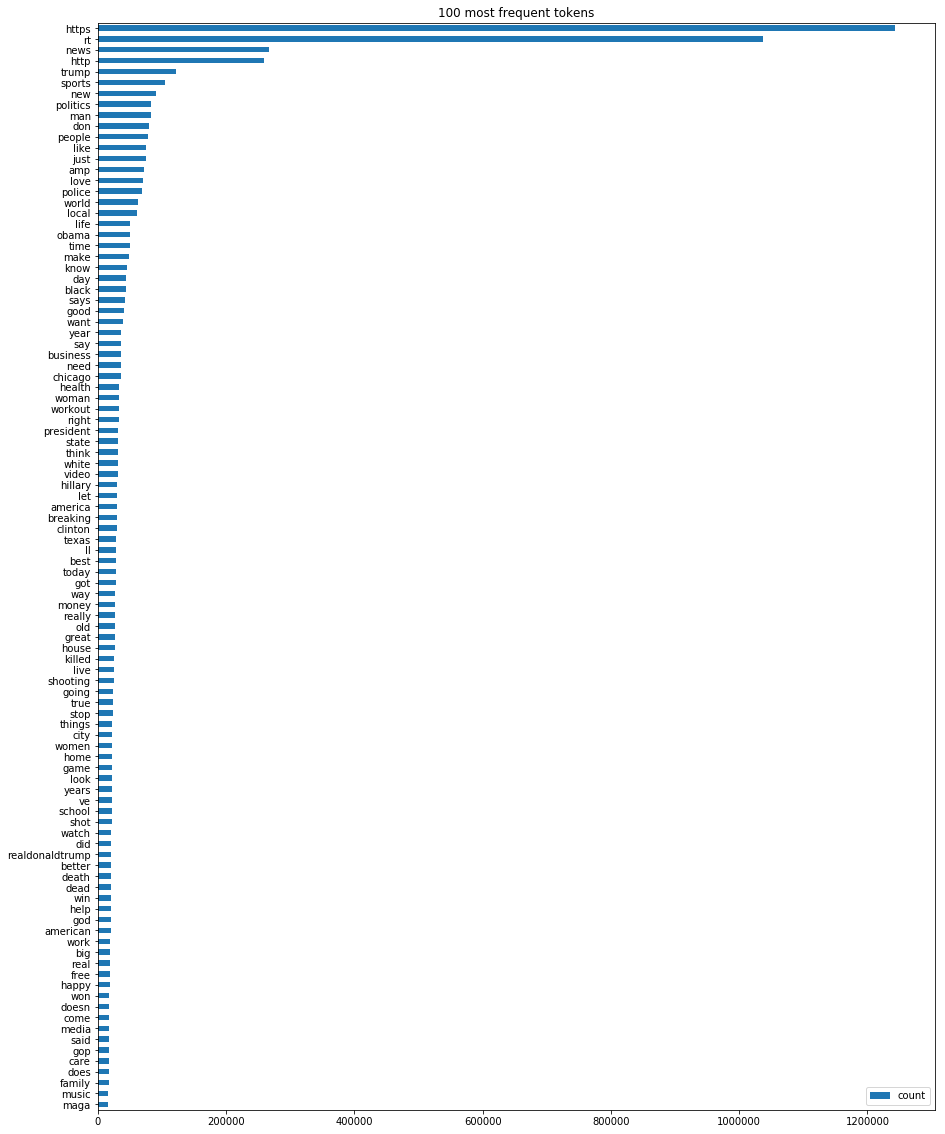

In [20]:
df_counts = (pd.DataFrame
             .from_dict(count_vect.vocabulary_, orient='index')
             .rename(columns={0: 'index'})
             .sort_values(by='index'))
df_counts['count'] = np.array(x_counts.sum(axis=0)).flatten()
df_counts = df_counts.drop(columns=['index'])
fig, ax = plt.subplots(figsize=(15,20))
ax.set_title('100 most frequent tokens')
df_counts.sort_values('count', ascending=False)[:100].sort_values('count').plot.barh(ax=ax);

### Tfidf

In [21]:
Image(url="https://i1.wp.com/datameetsmedia.com/wp-content/uploads/2017/05/bf.jpeg?w=1464")

Short for term frequency, inverse document frequency. Basically, if the term appears too often (the document frequency is too high), it's not that important and we should reduce its weight by dividing by the document frequency.

In [22]:
tfidf_vect = TfidfVectorizer(stop_words='english')

Again, this will take a couple of minutes...

In [23]:
%%time
x_tfidfs = tfidf_vect.fit_transform(df_users_eng_tweettext['tweet_text'])

CPU times: user 46.6 s, sys: 1.4 s, total: 48 s
Wall time: 48.1 s


In [24]:
x_tfidfs

<2191x1963375 sparse matrix of type '<class 'numpy.float64'>'
	with 6552422 stored elements in Compressed Sparse Row format>

With a tfidf encoding, what are some the most important tokens in the dataset?

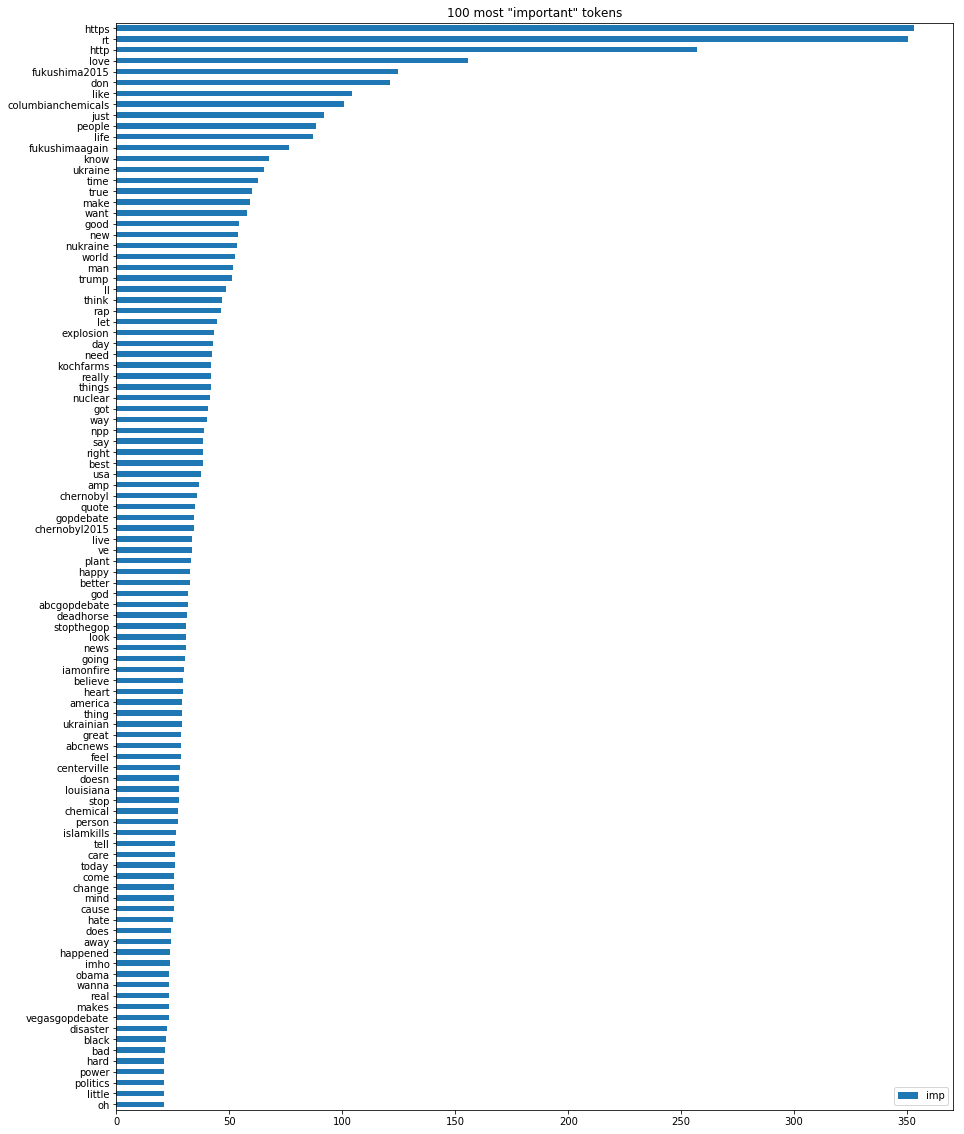

In [25]:
df_tfidfs = (pd.DataFrame
             .from_dict(tfidf_vect.vocabulary_, orient='index')
             .rename(columns={0: 'index'})
             .sort_values(by='index'))
df_tfidfs['imp'] = np.array(x_tfidfs.sum(axis=0)).flatten()
df_tfidfs = df_tfidfs.drop(columns=['index'])
fig, ax = plt.subplots(figsize=(15,20))
ax.set_title('100 most "important" tokens')
df_tfidfs.sort_values('imp', ascending=False)[:100].sort_values('imp').plot.barh(ax=ax);

Note: Summing Tfidf values and calling it 'importance' is kind of hand-wavy, but let's gloss over that for now.

## Dimensional Reduction

Remember, it's tough for our clustering algorithms to process high-dimensional data. We can use a dimensionality technique called SVD (very closely related to PCA) to reduce the number of dimensions from 2 million or so to something more tractable. The combination of tfidf and SVD is actually a fairly well known algorithm called LSA (latent semantic analysis). Let's try doing that.

Bonus tip: More on LSA [here](https://en.wikipedia.org/wiki/Latent_semantic_analysis).

In [26]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

How about 100 dimensions instead of ~2 million?

In [27]:
svd = TruncatedSVD(n_components=100, random_state=42)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

A few more minutes...

_(This may seem like a long time, but we're actually not doing too bad considering we're processing gigabytes of data in memory!)_

In [28]:
%%time
x_lsa = lsa.fit_transform(x_tfidfs)

CPU times: user 2min 26s, sys: 21.3 s, total: 2min 48s
Wall time: 1min 32s


In [29]:
print(f"""After some number crunching, we've finally arrived at {x_lsa.shape[0]} twitter accounts, 
each of which is represented by a {x_lsa.shape[1]}-dimensional vector.""")

After some number crunching, we've finally arrived at 2191 twitter accounts, 
each of which is represented by a 100-dimensional vector.


Remember the idea of "explained variance"? We can ask SVD how much explained variance we retained given the dimensional reduction.

Explained variance of the SVD step: 56%


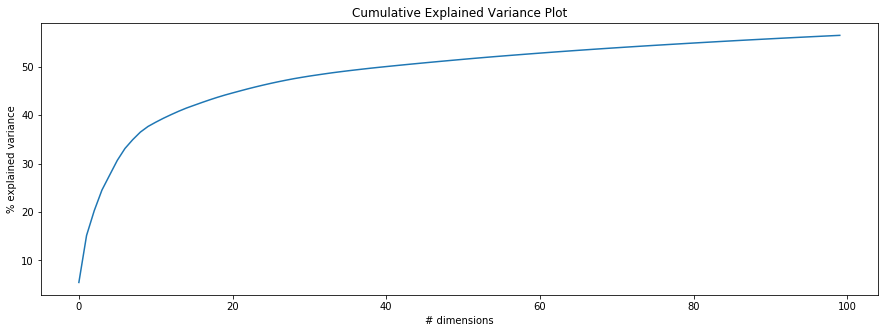

In [30]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title('Cumulative Explained Variance Plot')
ax.set_xlabel('# dimensions')
ax.set_ylabel('% explained variance')
df_ev = pd.DataFrame(data=svd.explained_variance_ratio_.cumsum()*100)
df_ev.plot(ax=ax)
ax.get_legend().remove()
explained_variance = svd.explained_variance_ratio_.sum()
print(f"Explained variance of the SVD step: {int(explained_variance * 100)}%")

We lost nearly all of the 2 million dimensions, but were still able to account for about half of the variation among the entries. Not doing too bad!

## Clustering: HDBSCAN

We could use any clustering algorithm on this 100-d data. But recall that HDBSCAN works surprisingly well on messy, real-world data. Because of the scikit-learn API, clustering is as simple as calling `fit_predict()`.

In [31]:
import hdbscan

In [32]:
%%time
target_hdbscan = hdbscan.HDBSCAN(min_cluster_size=7).fit_predict(x_lsa)

CPU times: user 598 ms, sys: 9.91 ms, total: 608 ms
Wall time: 573 ms


We've got our classifications -- now we can visualize these accounts. We still need to project from 100-dimensions back to 2-d. Remember UMAP?

In [33]:
import umap

In [34]:
%%time

# Separate out the features
x = x_lsa
reducer = umap.UMAP(random_state=42)
um = reducer.fit_transform(x)
df_um = pd.DataFrame(
    data = um,
    columns = ['x', 'y'],
    index = df_users_eng_tweettext.index
)

/anaconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 4 separate connected components using meta-embedding (experimental)
  n_components


CPU times: user 9.67 s, sys: 650 ms, total: 10.3 s
Wall time: 8.06 s


Let's plot out the accounts using a similar function as in the previous notebook.

In [35]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.palettes import Spectral10, d3, plasma
output_notebook()

Loading BokehJS ...

In [36]:
def plot_accounts(df_accounts, targets, proj_type, cluster_type=None):
    df_accounts['userid'] = df_accounts.index
    df_accounts['class'] = [str(x) for x in targets]
    datasource = ColumnDataSource(df_accounts)
    target_names = np.unique(targets)
    num_targets = len(target_names)
    palette = Spectral10
    if 10 < num_targets <= 20:
        palette = d3['Category20b'][num_targets]
    elif num_targets > 20:
        palette = plasma(num_targets)
    color_mapping = CategoricalColorMapper(
        factors=[str(len(target_names) - x) for x in target_names], palette=palette
    )
    
    title = f'{proj_type} projection of the accounts dataset'
    label = 'Class'
    if cluster_type:
        title = f'{proj_type} projection of the Digits dataset, clustered w/ {cluster_type}'


    plot_figure = figure(
        title=title,
        plot_width=700,
        plot_height=700,
        tools=('pan, wheel_zoom, reset')
    )

    plot_figure.add_tools(HoverTool(tooltips=f"""
    <div>
        <div>
            <span style='font-size: 9px'>@userid</span>
        </div>
        <div>
            <span style='font-size: 16px; color: #224499'>{label}:</span>
            <span style='font-size: 18px'>@class</span>
        </div>
    </div>
    """))

    plot_figure.circle(
        'x',
        'y',
        source=datasource,
        color=dict(field='class', transform=color_mapping),
        line_alpha=0.6,
        fill_alpha=0.6,
        size=3
    )

    show(plot_figure)

In [37]:
plot_accounts(df_um, target_hdbscan, 'UMAP', cluster_type=f"HDBSCAN, min_cluster_size=7; LSA w/ dim=100")

## Explore the clusters!

In [38]:
def get_userids_for_cluster(cluster_no):
    return df_um[df_um['class'] == str(cluster_no)][['class']].index

In [39]:
get_users(get_userids_for_cluster(0))

,user_display_name,user_screen_name,user_reported_location,user_profile_description,user_profile_url,follower_count,following_count,account_creation_date,account_language
userid,,,,,,,,,
0164c1125a1215e0d8626d542370dd14b792d3431cd23168e0d3bddd29c96f72,0164c1125a1215e0d8626d542370dd14b792d3431cd23168e0d3bddd29c96f72,0164c1125a1215e0d8626d542370dd14b792d3431cd23168e0d3bddd29c96f72,Syria,NaN,NaN,0,4,2015-10-12,en
09da7d709e1ba5e25b4bf3253a2fdfc97476be7c2e8c993685cd5a5195ab15b1,09da7d709e1ba5e25b4bf3253a2fdfc97476be7c2e8c993685cd5a5195ab15b1,09da7d709e1ba5e25b4bf3253a2fdfc97476be7c2e8c993685cd5a5195ab15b1,دمشق,NaN,NaN,1,8,2015-10-12,en
17e124ac4ca93f89481de3001a4c73fab2d786ffa5fa4445a6ce6a2b87fb3a61,17e124ac4ca93f89481de3001a4c73fab2d786ffa5fa4445a6ce6a2b87fb3a61,17e124ac4ca93f89481de3001a4c73fab2d786ffa5fa4445a6ce6a2b87fb3a61,حمص,NaN,NaN,2,5,2015-10-12,en
2dd5d1b7b76c29930275d4b257846d272720feccc7f2c5bce5bd59e1889681d5,2dd5d1b7b76c29930275d4b257846d272720feccc7f2c5bce5bd59e1889681d5,2dd5d1b7b76c29930275d4b257846d272720feccc7f2c5bce5bd59e1889681d5,سوريا,NaN,NaN,1,7,2015-10-12,en
4d5db44416e27521039c6a127ea28ab1ef8bd46a89970b6f48c7d698e66aaeab,4d5db44416e27521039c6a127ea28ab1ef8bd46a89970b6f48c7d698e66aaeab,4d5db44416e27521039c6a127ea28ab1ef8bd46a89970b6f48c7d698e66aaeab,اللاذقية,NaN,NaN,1,11,2015-10-12,en
506b4a46f4e2014f600bdcf1383d27688bbabf46e01a12f476ada9db89925f2d,506b4a46f4e2014f600bdcf1383d27688bbabf46e01a12f476ada9db89925f2d,506b4a46f4e2014f600bdcf1383d27688bbabf46e01a12f476ada9db89925f2d,حمص,NaN,NaN,0,9,2015-10-12,en
7988b13443d14268d0bbc4ff8ab6daaa4febd314a34bc3ea9b5650d6d2c30cc7,7988b13443d14268d0bbc4ff8ab6daaa4febd314a34bc3ea9b5650d6d2c30cc7,7988b13443d14268d0bbc4ff8ab6daaa4febd314a34bc3ea9b5650d6d2c30cc7,دمشق,NaN,NaN,1,10,2015-10-12,en
93a68a1faab9c3f26c4b6705f385e552fec0693c0c1c73ed3b584f3a83f1de6e,93a68a1faab9c3f26c4b6705f385e552fec0693c0c1c73ed3b584f3a83f1de6e,93a68a1faab9c3f26c4b6705f385e552fec0693c0c1c73ed3b584f3a83f1de6e,NaN,NaN,NaN,0,0,2015-10-12,en
a6c1734200da8f3c7da6b3841eccb5dc5720fab74e9ee34fea498e3854e20188,a6c1734200da8f3c7da6b3841eccb5dc5720fab74e9ee34fea498e3854e20188,a6c1734200da8f3c7da6b3841eccb5dc5720fab74e9ee34fea498e3854e20188,حلب,NaN,NaN,6,11,2015-10-12,en


In [40]:
get_tweets_eng_for_users(get_userids_for_cluster(0))

,userid,tweet_text,tweet_time,tweet_client_name
tweetid,,,,
653536842168561664,09da7d709e1ba5e25b4bf3253a2fdfc97476be7c2e8c993685cd5a5195ab15b1,RT @NUFC: INJURY NEWS: @TimKrul ruled out for the rest of the season with ruptured cruciate ligament. http://t.co/pvUlvlVJz2 http://t.co/8j…,2015-10-12 11:44,Twitter Web Client
653536807594934274,09da7d709e1ba5e25b4bf3253a2fdfc97476be7c2e8c993685cd5a5195ab15b1,RT @premierleague: David Beckham is on his way back to Old Trafford. Find out why: http://t.co/ZNstm5HR6s http://t.co/LOAgkt4rT6,2015-10-12 11:44,Twitter Web Client
653546981210615808,4d5db44416e27521039c6a127ea28ab1ef8bd46a89970b6f48c7d698e66aaeab,"RT @Audi: If you don’t have any plans this weekend, the #AudiA6 has 333 ideas for you. http://t.co/e6HRHsZq4U http://t.co/m0zlotsfNE",2015-10-12 12:25,Twitter Web Client
653547165244125185,4d5db44416e27521039c6a127ea28ab1ef8bd46a89970b6f48c7d698e66aaeab,"RT @BBCWalesSport: Real Madrid have not asked Wales to rest Gareth Bale against Andorra, says boss Chris Coleman http://t.co/8O8porLxv9 htt…",2015-10-12 12:26,Twitter Web Client
653553703253864448,b1f8ecb5c98b962137f8db689818f7403a665ce7dc4ec2b113463a81908ac778,RT @thesupertrofeo: #GuessTheLambo: could you list the differences between the Huracàn LP 610-4 and the Huracàn LP 620-2 #SuperTrofeo? http…,2015-10-12 12:51,Twitter Web Client
653553716172341249,b1f8ecb5c98b962137f8db689818f7403a665ce7dc4ec2b113463a81908ac778,RT @Pirelli: Want to drive a @Lamborghini Aventador Pirelli Edition? Grasp your chance: #ChasingTheCal http://t.co/UD6oxyZwKa http://t.co/K…,2015-10-12 12:52,Twitter Web Client
653555704322748416,a6c1734200da8f3c7da6b3841eccb5dc5720fab74e9ee34fea498e3854e20188,"RT @orologidiclasse: Enjoyed to go ""in depth"" with The #Longines Heritage Diver 1967 http://t.co/5NJZdIz9Fq hands-on and his history. http:…",2015-10-12 12:59,Twitter Web Client
653555805199966208,a6c1734200da8f3c7da6b3841eccb5dc5720fab74e9ee34fea498e3854e20188,RT @TISSOT: Meet &amp; Greet with #TissotAmbassador @ThomasLUTHI in Bern from 14.00 - 15.00 ! Let's meet there! http://t.co/T3By7OgiMp,2015-10-12 13:00,Twitter Web Client
653557410347511808,fa0310ba2e63cef27a0bf1fe049b79c54214543e3b6ab3c8b49dfe306d2bfb23,"RT @FIFAcom: Happy birthday to @phganso (26), @CristhianStuani (29), @LedleyKing (35) &amp; Wim Jonk (49) http://t.co/6ulbhBAiDR http://t.co/dT…",2015-10-12 13:06,Twitter Web Client


Fascinating -- seems like a bunch of accounts that tweeted about soccer and Syria.

In [45]:
get_users(get_userids_for_cluster(45))

,user_display_name,user_screen_name,user_reported_location,user_profile_description,user_profile_url,follower_count,following_count,account_creation_date,account_language
userid,,,,,,,,,
0e45d2af1bbca512ab1d8fa1c2216c038f9627bb773ab4cbe351404ee7a2c93e,0e45d2af1bbca512ab1d8fa1c2216c038f9627bb773ab4cbe351404ee7a2c93e,0e45d2af1bbca512ab1d8fa1c2216c038f9627bb773ab4cbe351404ee7a2c93e,NaN,"Honor God & Jesus & Your Parents Country, GOP, I Follow Back #tcot #RedNationRising #InGodWeTrust",NaN,1812,2053,2013-07-26,en
1cd9dcae39203ce9df705a6ff0cb4b1961effb11c9959e48055606a108fedd44,1cd9dcae39203ce9df705a6ff0cb4b1961effb11c9959e48055606a108fedd44,1cd9dcae39203ce9df705a6ff0cb4b1961effb11c9959e48055606a108fedd44,USA,"Retired Chief Financial Officer, Patriot, Conservative Constitutionalist, 2nd Amend Supporter, Penn State Grad - Political Science, Fitness Enthusiast",NaN,1578,1626,2015-03-10,en
1fdac06ebb156f54ed03ca124d7faa8638dff2e7229910e4b52c0149b18dd7f0,1fdac06ebb156f54ed03ca124d7faa8638dff2e7229910e4b52c0149b18dd7f0,1fdac06ebb156f54ed03ca124d7faa8638dff2e7229910e4b52c0149b18dd7f0,USA,I am a True Conservative and I love my country with all my heart! Happily married....,NaN,1597,1842,2013-08-11,en
27b93ba228eb4137131221eea1f595b141182ee2c99db530c25351276ff8b962,27b93ba228eb4137131221eea1f595b141182ee2c99db530c25351276ff8b962,27b93ba228eb4137131221eea1f595b141182ee2c99db530c25351276ff8b962,NaN,Constitutional conservative-Pro life-Pro 2nd amendment-Christian,NaN,2491,2974,2015-03-10,en
2aae433624dcea729731ff8e44b0bdedc56e7cc9eea9bedd14bb264b07eedd5c,2aae433624dcea729731ff8e44b0bdedc56e7cc9eea9bedd14bb264b07eedd5c,2aae433624dcea729731ff8e44b0bdedc56e7cc9eea9bedd14bb264b07eedd5c,NaN,#JESUS IS MY LOVE - TEA PARTY. ARREST OBAMA REGIME #TCOT #RedNationRising #InGodWeTrust,NaN,1787,1856,2015-03-10,en
2e27054a9e525b4167ec99331558659a59996dc3711e36aee02d5ec78817161e,2e27054a9e525b4167ec99331558659a59996dc3711e36aee02d5ec78817161e,2e27054a9e525b4167ec99331558659a59996dc3711e36aee02d5ec78817161e,United States,"Father of twin daughters. Conservative Republican. Interested in world events, politics, and sports. RT= whatever I find interesting",NaN,1815,1735,2013-08-24,en
349144213c3141c70f1021f47d801f6e7bb56dd7faa3302b023b0e82c0f70869,349144213c3141c70f1021f47d801f6e7bb56dd7faa3302b023b0e82c0f70869,349144213c3141c70f1021f47d801f6e7bb56dd7faa3302b023b0e82c0f70869,USA,"Christian, Husband, Father, American, Conservative, Tea Party, Fisherman, Gun Owner, Engineer, USN Vet #BodyLife #TCOT #TGDN #2A #TPFA #CruzCrew #PJNET",NaN,1528,1499,2014-05-12,en
396b0b6914e425ca53c49b7f1d6cfe9757eb7368c04c657a09d83b19a8f1251e,396b0b6914e425ca53c49b7f1d6cfe9757eb7368c04c657a09d83b19a8f1251e,396b0b6914e425ca53c49b7f1d6cfe9757eb7368c04c657a09d83b19a8f1251e,USA,~Reagan Conservative ~Jesus Lover ~PRO-Israel ~PRO-2A ~PRO-Life ~PRO-Constitution ~Support Police & Military #RenewUS #PJNET #TCOT #CruzCrew #WakeUpAmerica,NaN,2372,2616,2013-08-14,en
4740b9b1f375bd679d01241d3ab611fba8d8ef213f746a43b0d01d1c0131f969,4740b9b1f375bd679d01241d3ab611fba8d8ef213f746a43b0d01d1c0131f969,4740b9b1f375bd679d01241d3ab611fba8d8ef213f746a43b0d01d1c0131f969,NaN,"Stand with God, Family, Constitution & 2A. On A Mission 2Save America. LIBS R BLOCKED #WakeUpAmerica #tcot #GodBlessAmerica",NaN,1778,1833,2013-08-06,en


In [46]:
get_tweets_eng_for_users(get_userids_for_cluster(45))

,userid,tweet_text,tweet_time,tweet_client_name
tweetid,,,,
482645190029889536,349144213c3141c70f1021f47d801f6e7bb56dd7faa3302b023b0e82c0f70869,"Relationships break up when one listens to gossips without asking ""is it true?"".",2014-06-27 22:02,Twitter Web Client
483128377864638464,349144213c3141c70f1021f47d801f6e7bb56dd7faa3302b023b0e82c0f70869,You aren't the person I knew back then.,2014-06-29 06:02,Twitter Web Client
484629459782619136,349144213c3141c70f1021f47d801f6e7bb56dd7faa3302b023b0e82c0f70869,"I dont need to see the sun again, there is enough light in your eyes to light up all the world.",2014-07-03 09:27,Twitter Web Client
486163564336779264,349144213c3141c70f1021f47d801f6e7bb56dd7faa3302b023b0e82c0f70869,Get it right twi-hards rad Pitt the original HOT vampire!,2014-07-07 15:03,Twitter Web Client
486184618685894656,349144213c3141c70f1021f47d801f6e7bb56dd7faa3302b023b0e82c0f70869,Never underestimate the insane. Especially if you are. :),2014-07-07 16:27,Twitter Web Client
488745973032964096,e9e55093f99066a1802191d1dd7e43661a118501b7e0ed75cee9cb7803709ae6,I am in Love with LOVE!,2014-07-14 18:04,Twitter Web Client
490059151939502080,5625ccf109dc80b224458990f8709832900faecd798b9fa9f7d416f00db22e08,"If tears could build a staircase up to heaven, I'd come up there and bring you right back down here",2014-07-18 09:03,Twitter Web Client
490080707944128512,5625ccf109dc80b224458990f8709832900faecd798b9fa9f7d416f00db22e08,"Life will throw you curve balls, may God straighten them out before you catch them!",2014-07-18 10:28,Twitter Web Client
490598308449370112,5625ccf109dc80b224458990f8709832900faecd798b9fa9f7d416f00db22e08,It is human nature to think wisely and act in an absurd fashion.,2014-07-19 20:45,Twitter Web Client


^ Accounts posing as conservative Americans? Whoa.

Do your own explorations based on the code samples and metadata! There's a lot to uncover!

## Wrap-up

Some useful text here.